# SAT Scores in Neq York City Schools
This project explores a number of correlations between various background characteristics in and SAT scores in NYC schools. The focus in this project, however, is to show how to compile data from various public open data sources and bring it into a shape that can be analysed. In this case, the data comes from the [public data repository](https://data.cityofnewyork.us/browse?category=Education) of the City of New York.

## Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Set up matplotlib

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# Correlation between `sat_score` and the survey columns

In [17]:
corr_sat_survey = combined.corr()
corr_sat_survey = corr_sat_survey["sat_score"]
corr_sat_survey = corr_sat_survey[survey_fields]
print(corr_sat_survey)

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


## Plotting the correlations

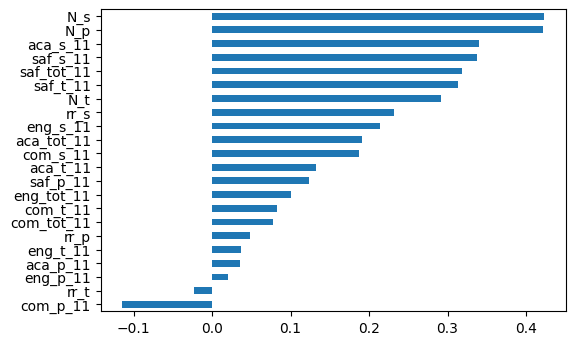

In [18]:
# Making a horizontal bar chart
sorted_data = corr_sat_survey.sort_values() # Sort the data
bar_plot = sorted_data.plot.barh() # Create the bar plot
plt.show()

Higher correlations (r > .25) are observed for `N_s` (Number of student respondents), `N_p` (Number of parent respondents), `aca_s_11` (Academic expectations score based on student responses), `saf_s_11` (Safety and Respect score based on student responses), `saf_tot_11` (Safety and Respect total score) and `N_t`(Number of teacher respondents). However, engagement scores, rated by either group (students, parents or teachers), as well as communication scores are not strongly related to SAT scores. A higher correlation for these kind of soft indicators would have been expected. The academic expectation ratings from parents and teachers are also not very predictive. Eventually, the correlation between school size indicators and SAT looks high, but we know that this is a somewhat spurious correlation based on the fact that many schools with a high share of new English learners are small and have worse SAT scores. Therefore, the more interesting predictors here are the academic expectations based on studnet ratings (`aca_s_11`) as well as the safety and respcect indicators `saf_s_11`, `saf_t_11`, `saf_tot_11`. It might be sufficient to only look at the total safetc and respect indicator.

## Exploring safety and SAT scores

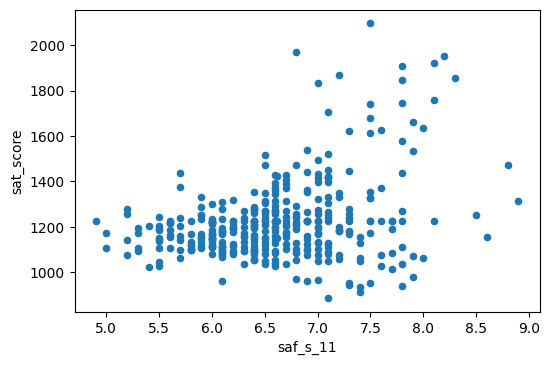

In [20]:
combined.plot.scatter(x="saf_s_11", y="sat_score")
plt.show()

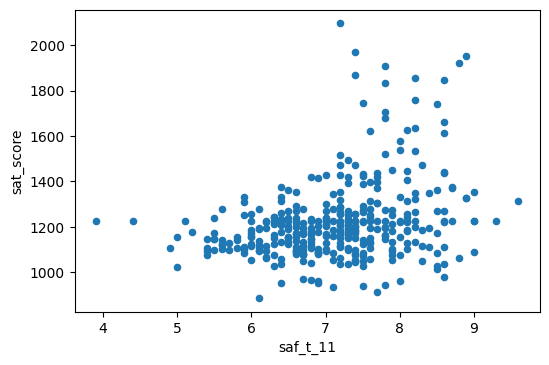

In [21]:
combined.plot.scatter(x="saf_t_11", y="sat_score")
plt.show()

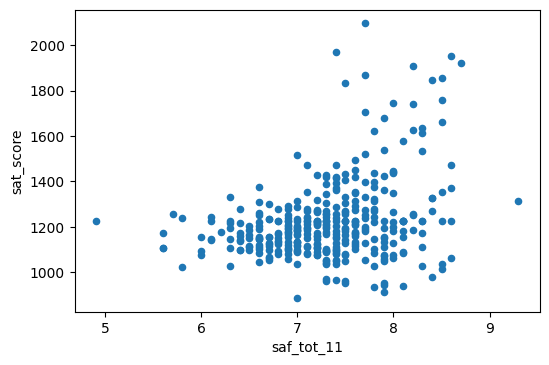

In [22]:
combined.plot.scatter(x="saf_tot_11", y="sat_score")
plt.show()

The plots between `saf_s_11`, `saf_t_11`, `saf_tot_11` and `sat_score` all point towards a positive correlation between respect and safety and higher SAT scores. Additionally, this relationship does not seem to be driven by outliers. The safety perception might, however, be clustered geographically. And in this case, we see some cluster of positive safety perceptions and high SAT scores. This might be schools in suburban areas, for example. Let's investigate by examining the average SAT-scores by borough.

## Computing safety scores by borough

In [32]:
district_safety = combined.groupby('boro')['saf_s_11'].mean().sort_values()
print(district_safety)


boro
Brooklyn         6.370755
Staten Island    6.530000
Bronx            6.606577
Queens           6.721875
Manhattan        6.831370
Name: saf_s_11, dtype: float64


Brooklyn, Staten Island, and Bronx have comparatively lower safety scores, whereas Manhattan and Queens are perceived as fairly safe by students.

## Exploring race and SAT scores

In [33]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
corr_sat_race = combined.corr()
corr_sat_race = corr_sat_race["sat_score"]
corr_sat_race = corr_sat_race[races]
print(corr_sat_race)


white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64


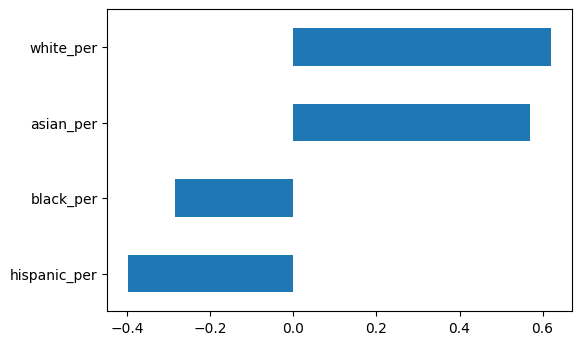

In [34]:
# Making a horizontal bar chart
sorted_data = corr_sat_race.sort_values() # Sort the data
bar_plot = sorted_data.plot.barh() # Create the bar plot
plt.show()

We find strong positive correlations with average SAT scores and the percentage of White (r = .62) and Asian (r = .57) students in a school. There are moderately negative correlations between the percentage of Black (r = -.28) and Hispanic (r = -0.40) students in a school. These findings have been observed before in the literature. They are probably related to differences in SES, with Black and Hispanic students often coming from poorer economic backgrounds, leading to lower SES scores. Additionally, these scores might reflect racial discrimination against Black and Hispanic students.

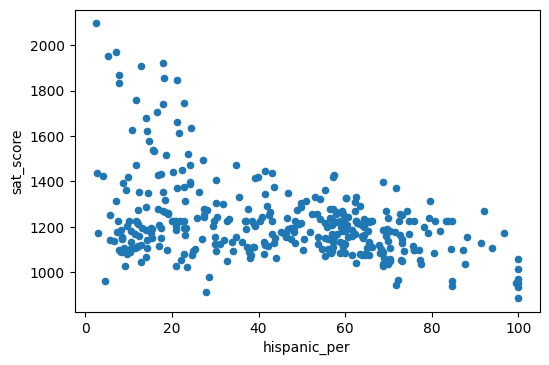

In [35]:
# closer look at the correlation between percentage of Hispanic students and average SAT scores

combined.plot.scatter(x="hispanic_per", y="sat_score")
plt.show()

This looks like an interesting pattern. In fact, the plot does not so much support the idea that a high share of Hispanic students is strongly correlated to lower SAT scores. Rather the relationship seems to be driven more strongly by the schools that have a very low share of Hispanic students and a very strong average SAT. Nonetheless, there are also schools which are exclusively (or almost exclusively) Hispanic, which show a low average SAT score. It makes sense to examine both cases more closely.

In [38]:
# schools with a share of more than 95% Hispanic

hispanic = combined[['SCHOOL NAME', 'hispanic_per']]
hispanic = hispanic[hispanic['hispanic_per'] > 95]
print(hispanic['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


It looks like the schools with a very high percentage of Hispanic students are schools for newly immigrated Spanish speaking students, that are still beginning to learn English. This explains why the overall SAT levels are lower in these schools: the English language skills are not yet sufficient to reach the full potential in SAT exams. What about the schools with very few Hispanic students?

In [39]:
# schools with a share of less than 10% Hispanic

no_hispanic = combined[['SCHOOL NAME', 'hispanic_per']]
no_hispanic = no_hispanic[no_hispanic['hispanic_per'] < 10]
print(no_hispanic['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           B

For one, this list contains schools with very exclusive entrance exams, like Stuyvesant High School. That particular school has  avery low Hispanic student intake. The other schools are technical schools, also with entrance exams. While the selectivity on terms of entrance exams explains their better average SAT scores, and does not really explain why Hispanic students are so underrepresented in these schools.

## Exploring gender and SAT scores

In [40]:
genders = ['male_per', 'female_per']
corr_sat_gender = combined.corr()
corr_sat_gender = corr_sat_gender["sat_score"]
corr_sat_gender = corr_sat_gender[genders]
print(corr_sat_gender)

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64


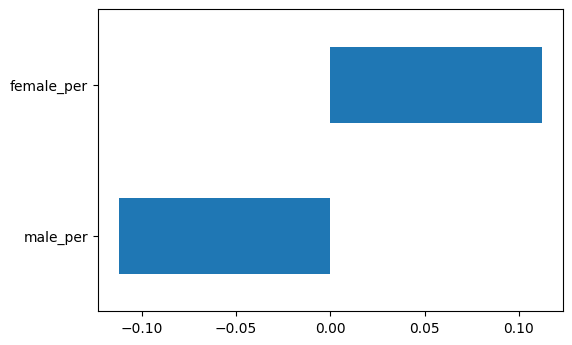

In [41]:
# Making a horizontal bar chart
sorted_data = corr_sat_gender.sort_values() # Sort the data
bar_plot = sorted_data.plot.barh() # Create the bar plot
plt.show()

Here we can see that schools with a higher share of female students perform somewhat better than those with a higher share of male students. But the correlation of 0.11 is quite weak.

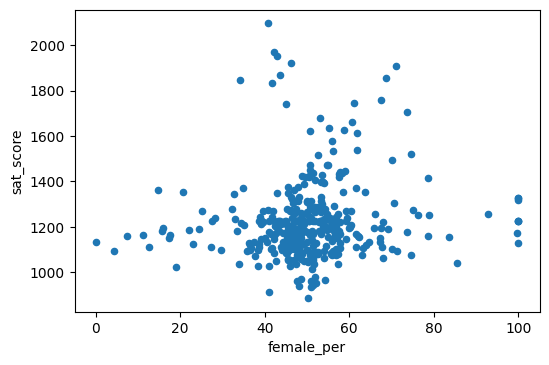

In [42]:
# closer look at the correlation between female share and SAT scores

combined.plot.scatter(x="female_per", y="sat_score")
plt.show()

Based on the scatter plot, there doesn't seem to be any real correlation between `sat_score` and `female_per`. However, there is a cluster of schools with a high percentage of females (60 to 80) and high SAT scores.

In [44]:
# schools with a high share of female students and a high SAT score

high_female = combined[['SCHOOL NAME', 'female_per', 'sat_score']]
high_female = high_female[(high_female['female_per'] > 60) & (high_female['sat_score'] > 1700)]
print(high_female['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appear to be very selective liberal arts schools that have high academic standards.

##  Exploring AP scores vs. SAT scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because `total_enrollment` is highly correlated with `sat_score`, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

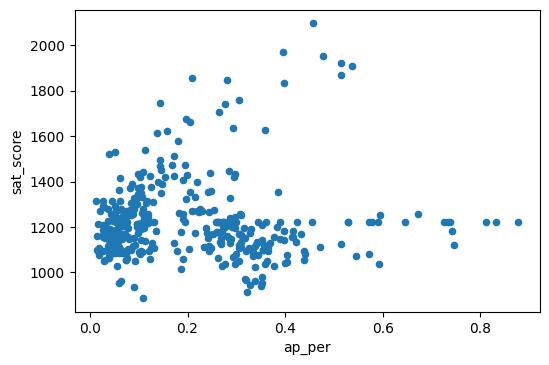

In [45]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

# scatter plot of percentage AP test takers and SAT scores

combined.plot.scatter(x="ap_per", y="sat_score")
plt.show()


It seems as if the relationship between AP test takers and average SAT scores does not hold for the overall sample. Rather, there is "forking" in the scatter plot, a positive relationship for a cluster of schools with up to 50% AP test takers and on average higher SAT scores, and no correlation for the rest of the sample. This could mean that there are schools that have special entry requirements, which we find here in this cluster.